In [ ]:
#!pipenv install pandas plotly scikit-learn optuna ipywidgets ipykernel nbformat matplotlib pingouin gradio

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer


import optuna

In [2]:
clientes = pd.read_csv('clientes.csv')

In [3]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 23.6+ KB


In [4]:
clientes.head()

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao
0,Comércio,713109.95,12,Rio de Janeiro,6,1
1,Comércio,790714.38,9,São Paulo,15,0
2,Comércio,1197239.33,17,São Paulo,4,9
3,Indústria,449185.78,15,São Paulo,6,0
4,Agronegócio,1006373.16,15,São Paulo,15,8


In [5]:
clientes.tail()

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao
495,Serviços,1581841.42,17,Rio de Janeiro,8,2
496,Indústria,1291309.57,9,São Paulo,6,9
497,Serviços,2211489.85,10,Belo Horizonte,10,0
498,Agronegócio,1460860.46,12,Rio de Janeiro,5,3
499,Indústria,173684.43,13,Belo Horizonte,4,9


In [6]:
clientes.describe()

,faturamento_mensal,numero_de_funcionarios,idade,inovacao
count,500.00,500.00,500.00,500.00
mean,1026715.63,13.69,9.25,4.39
std,420609.46,3.12,2.96,2.90
min,18421.22,2.00,0.00,0.00
25%,763253.58,12.00,7.00,2.00
50%,1022957.08,14.00,9.00,4.00
75%,1295888.52,16.00,11.00,7.00
max,2390677.22,21.00,16.00,9.00


In [7]:
import seaborn as sns

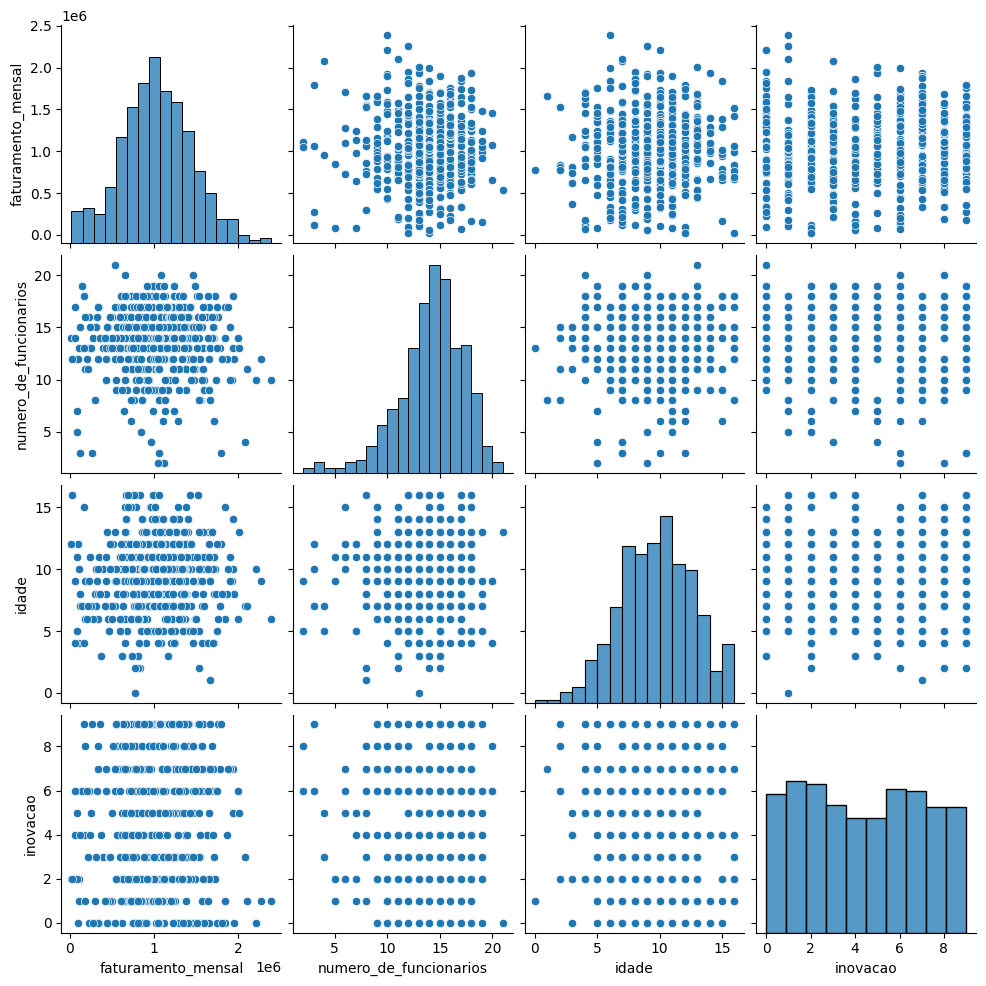

In [8]:
sns.pairplot(data=clientes)

In [9]:
clientes.atividade_economica.unique()
clientes_eda = clientes.drop(columns=['atividade_economica', 'localizacao'], axis=1)

<Axes: >

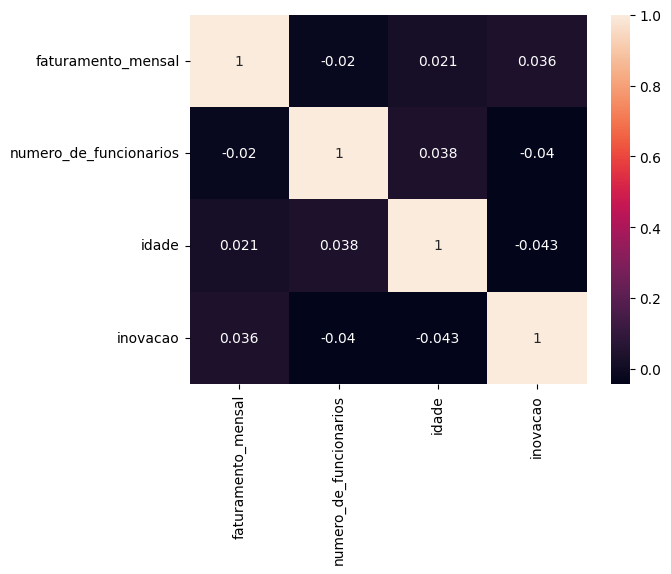

In [10]:
sns.heatmap(data=clientes_eda.corr(), annot=True)

# EDA

In [12]:
percentual_inovacao = clientes.value_counts('inovacao') / len(clientes) * 100
px.bar(percentual_inovacao, color=percentual_inovacao.index)

In [13]:
# Teste ANOVA (Análise de variância) - Verifica de há variações significativas na média de faturamento mensal para diferentes níveis de inovação
# Suposições / Pressuposto:
# Variável dependente é contínua
# Segue uma distribuição normal
# Homogeneidade das variâncias
# Amostras sejam de tamanhos iguais

In [14]:
# Checar se as variâncias (faturamento) entre os grupos (inovação) são homogêneas
# Aplicar Teste de Bartlett
# H0 - Variâncias são iguais
# H1 - Variâncias não são iguais

from scipy.stats import bartlett

dados_agrupados = [clientes['faturamento_mensal'][clientes['inovacao'] == grupo] for grupo in clientes['inovacao'].unique()]

bartlett_test_statistic, bartlett_p_value = bartlett(*dados_agrupados)

In [15]:
print(bartlett_test_statistic)

10.901203117231173


In [16]:
print(bartlett_p_value)

0.2825418295490583


In [17]:
# p_value > 0.05, não rejeitamos H0, portanto as variáveis são homogêneas

In [18]:
# Teste de Shapiro-Wilk
# Verificar se os dados seguem uma distribuição normal
# H0 - Segue uma distribuição normal
# H1 - Não segue uma distribuição normal

from scipy.stats import shapiro
shapiro_test, shapiro_p_value = shapiro(clientes['faturamento_mensal'])
print(shapiro_test, shapiro_p_value)

0.9959857602472714 0.2351345103439314


In [19]:
# p_value > 0.05, não rejeitamos H0, portanto faturamento_mensal segue distribuição normal

In [29]:
# Aplicas ANOVA de Welch , pois as amostras são de tamanhos diferentes
# H0 - Não há diferenças significativas entre as médias dos grupos
# H1 - Há pelo menos uma diferença significativa entre as médias dos grupos
from pingouin import welch_anova  

aov = welch_anova(dv='faturamento_mensal', between='inovacao', data=clientes)

print(aov.loc[0, 'F'], '\np_value: ', aov.loc[0, 'p-unc'], '\nNão rejeitamos H0 portanto não há diferenças significativas entre as médias dos grupos.')

1.126983619406169 
p_value:  0.34526211273912644 
Não rejeitamos H0 portanto não há diferenças significativas entre as médias dos grupos.


### Treinar algoritmo KMeans

In [30]:
X = clientes.copy()

In [31]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   atividade_economica     500 non-null    object 
 1   faturamento_mensal      500 non-null    float64
 2   numero_de_funcionarios  500 non-null    int64  
 3   localizacao             500 non-null    object 
 4   idade                   500 non-null    int64  
 5   inovacao                500 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 23.6+ KB


In [32]:
num = ['faturamento_mensal', 'numero_de_funcionarios', 'idade']
cat = ['atividade_economica', 'localizacao']
ordinal = ['inovacao']

num_tranformer = StandardScaler()
cat_transformer = OneHotEncoder()
ord_transformer = OrdinalEncoder()

preprocessor = ColumnTransformer(
  transformers=[
    ('num', num_tranformer, num),
    ('cat', cat_transformer, cat),
    ('ord', ord_transformer, ordinal)
  ]
)

X_transformed = preprocessor.fit_transform(X)

In [35]:
X_transformed

array([[-0.74634498, -0.54179191, -1.10058849, ...,  0.        ,
         0.        ,  1.        ],
       [-0.56165548, -1.5035527 ,  1.94344851, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.40582654,  1.06114274, -1.77704115, ...,  1.        ,
         0.        ,  9.        ],
       ...,
       [ 2.8196246 , -1.18296577,  0.25231684, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.03321411, -0.54179191, -1.43881482, ...,  0.        ,
         0.        ,  3.        ],
       [-2.03011486, -0.22120498, -1.77704115, ...,  0.        ,
         0.        ,  9.        ]])

In [38]:
# Qual a melhor configuração de Clusters
def kmeans_objective(trial):
  n_clusters = trial.suggest_int('n_clusters', 3, 10)
  distance_metric = trial.suggest_categorical('distance_metric', ['euclidean', 'minkowski'])
  
  kmeans_model = KMeans(n_clusters=n_clusters, random_state=51)
  
  kmeans_model.fit(X_transformed)
  
  distances = pairwise_distances(X_transformed, metric=distance_metric)
  silhouette_avg = silhouette_score(distances, kmeans_model.labels_)
  
  return silhouette_avg

In [39]:
# Criar estudo do Optuna
search_space = {'n_clusters': [3, 4, 5, 6, 7, 8, 9, 10], 'distance_metric': ['euclidean', 'minkowski']}
sampler = optuna.samplers.GridSampler(search_space=search_space)
estudo_kmeans = optuna.create_study(direction='maximize', sampler=sampler)

estudo_kmeans.optimize(kmeans_objective, n_trials=100)

[I 2024-08-03 15:51:20,802] A new study created in memory with name: no-name-14a861a2-d1cb-4879-9a18-532bad385027
[I 2024-08-03 15:51:20,889] Trial 0 finished with value: 0.32513462925255826 and parameters: {'n_clusters': 5, 'distance_metric': 'euclidean'}. Best is trial 0 with value: 0.32513462925255826.
[I 2024-08-03 15:51:20,896] Trial 1 finished with value: 0.4445458290999088 and parameters: {'n_clusters': 3, 'distance_metric': 'euclidean'}. Best is trial 1 with value: 0.4445458290999088.
[I 2024-08-03 15:51:20,904] Trial 2 finished with value: 0.10407102359393554 and parameters: {'n_clusters': 10, 'distance_metric': 'minkowski'}. Best is trial 1 with value: 0.4445458290999088.
[I 2024-08-03 15:51:20,910] Trial 3 finished with value: 0.38478794965029234 and parameters: {'n_clusters': 4, 'distance_metric': 'euclidean'}. Best is trial 1 with value: 0.4445458290999088.
[I 2024-08-03 15:51:20,916] Trial 4 finished with value: 0.14731572416665692 and parameters: {'n_clusters': 8, 'dista

In [41]:
kmeans_best_model = KMeans(n_clusters=3, random_state=51)
kmeans_best_model.fit(X_transformed)

KMeans(n_clusters=3, random_state=51)

In [43]:
distances = pairwise_distances(X_transformed, metric='euclidean')
print(distances)

[[ 0.          3.6366544   8.38775816 ...  4.4673925   3.04651073
   8.37904704]
 [ 3.6366544   0.         10.11710074 ...  4.28902754  5.28283049
  10.13127988]
 [ 8.38775816 10.11710074  0.         ...  9.99903685  6.56333846
   3.40267927]
 ...
 [ 4.4673925   4.28902754  9.99903685 ...  0.          4.41160885
  10.56235062]
 [ 3.04651073  5.28283049  6.56333846 ...  4.41160885  0.
   7.04280892]
 [ 8.37904704 10.13127988  3.40267927 ... 10.56235062  7.04280892
   0.        ]]


In [44]:
print(silhouette_score(distances, kmeans_best_model.labels_))

0.4445458290999088


In [46]:
clientes['clusters'] = kmeans_best_model.labels_

In [47]:
clientes.head()

,atividade_economica,faturamento_mensal,numero_de_funcionarios,localizacao,idade,inovacao,clusters
0,Comércio,713109.95,12,Rio de Janeiro,6,1,0
1,Comércio,790714.38,9,São Paulo,15,0,0
2,Comércio,1197239.33,17,São Paulo,4,9,1
3,Indústria,449185.78,15,São Paulo,6,0,0
4,Agronegócio,1006373.16,15,São Paulo,15,8,1


In [48]:
px.scatter(clientes, x='idade', y='faturamento_mensal', color='clusters')

In [49]:
px.scatter(clientes, x='inovacao', y='faturamento_mensal', color='clusters')

In [50]:
px.scatter(clientes, x='atividade_economica', y='faturamento_mensal', color='clusters')

In [52]:
px.scatter(clientes, x='numero_de_funcionarios', y='faturamento_mensal', color='clusters')